Introduction:
Dans un monde de plus en plus connecté, la cybersécurité devient une priorité absolue pour protéger les systèmes informatiques contre les menaces croissantes. Le dataset UNSW-NB15 est conçu pour répondre à ce besoin en proposant des données qui simulent le trafic réseau, y compris des caractéristiques des attaques. Ce projet vise à analyser et à modéliser les données du dataset UNSW-NB15 pour détecter les comportements anormaux et potentiellement malveillants dans le réseau. En appliquant différentes techniques de machine learning et de deep learning, ce projet cherche à identifier les modèles qui offrent la meilleure précision pour distinguer les activités normales des activités suspectes. Ce travail constitue une contribution importante au développement de systèmes de détection d'intrusion capables de répondre aux défis de la cybersécurité actuelle. 
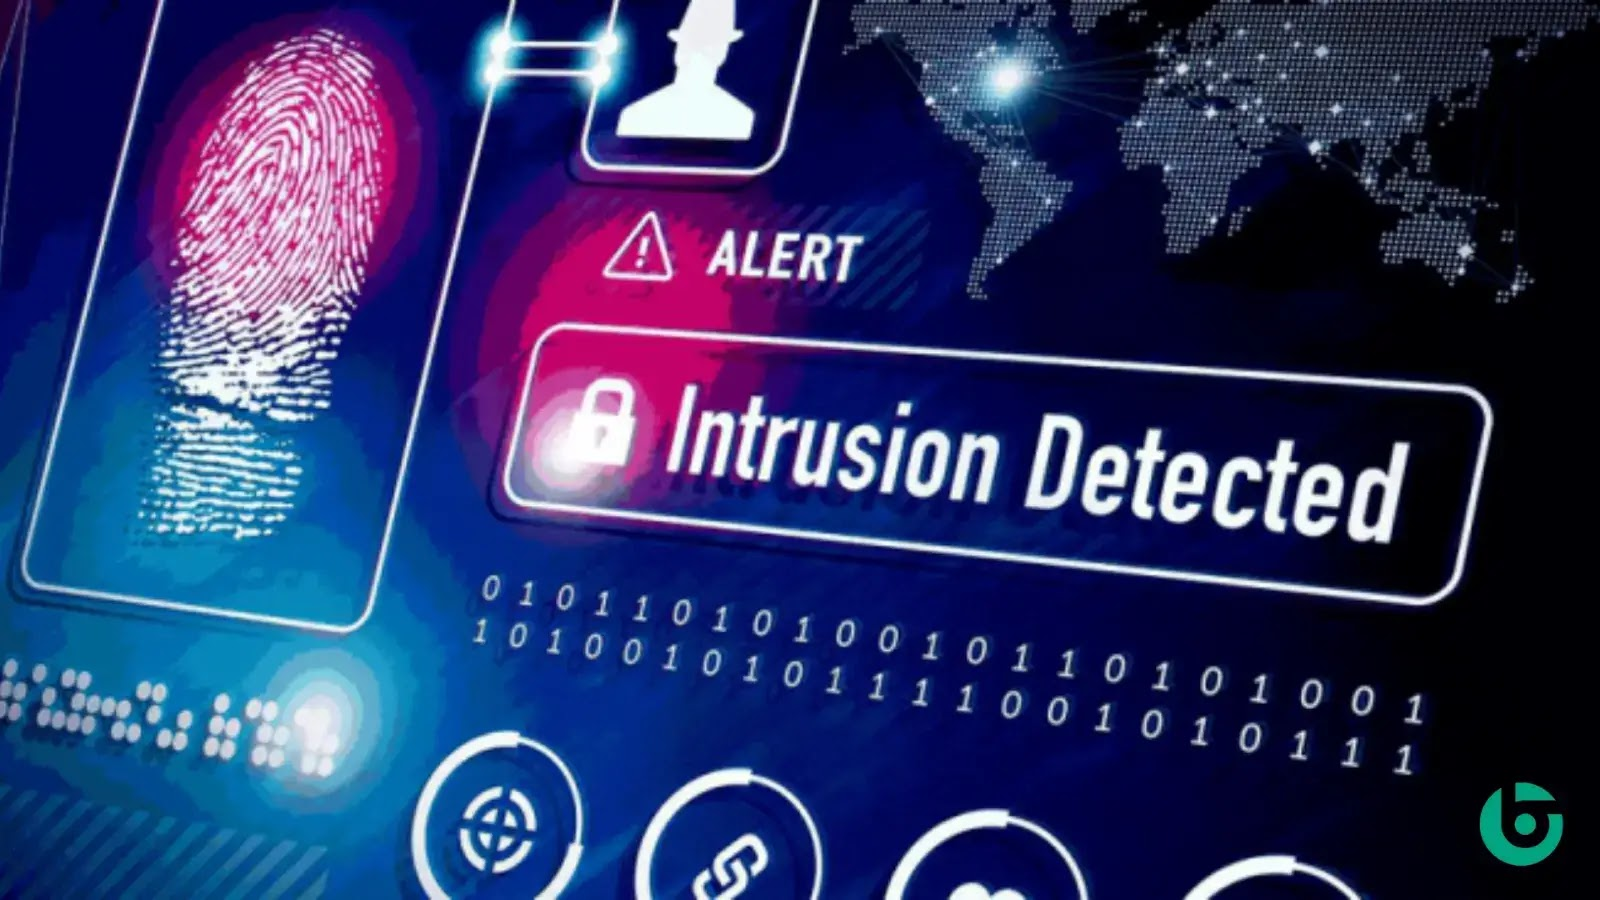

In [1]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [68]:
# Importer les bibliothèques nécessaires
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

In [82]:
# Charger les datasets
file_path1 = "UNSW_NB15.csv"
file_path2 = "UNSW_NB15_features.csv"

data = pd.read_csv(file_path1)
data_features = pd.read_csv(file_path2)

In [83]:
# Afficher les premières lignes du dataset principal pour vérification
data.head()


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [84]:
# Afficher les premières lignes du dataset principal pour vérification
data_features.head()

,No.,Name,Type,Description
0,1,srcip,nominal,Source IP address
1,2,sport,integer,Source port number
2,3,dstip,nominal,Destination IP address
3,4,dsport,integer,Destination port number
4,5,proto,nominal,Transaction protocol


In [85]:
# Supprimer les lignes où la colonne 'service' contient '-'
data = data[data['service'] != '-']

# Vérification des valeurs uniques dans la colonne 'service' après suppression
print("Valeurs uniques dans 'service':", data['service'].unique())

Valeurs uniques dans 'service': ['ftp' 'smtp' 'snmp' 'http' 'ftp-data' 'dns' 'ssh' 'radius' 'pop3' 'dhcp'
 'ssl' 'irc']


In [86]:
# Convert the 'label' column to boolean type for easier handling of binary classification (True/False)
data.loc[:, 'label'] = data['label'].astype(bool)

StandardScaler : StandardScaler est une classe de la bibliothèque sklearn.preprocessing qui permet de standardiser les caractéristiques (features) en leur appliquant une transformation pour que chaque caractéristique ait une moyenne de 0 et un écart type de 1. Cela permet d'assurer que toutes les colonnes numériques ont la même échelle 


In [87]:
# Sélection automatique des colonnes numériques pour standardisation
columns_to_standardize = data.select_dtypes(include=['float64', 'int64']).columns

# Standardiser les colonnes numériques
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[columns_to_standardize])

# Mettre à jour le DataFrame avec les valeurs standardisées
data.loc[:, columns_to_standardize] = scaled_features

In [88]:
# Verify that the columns are standardized by checking their mean and standard deviation
data[columns_to_standardize].describe().loc[['mean', 'std']]


,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
mean,-4.481760e-17,-1.680660e-17,5.602200e-18,0.000000,4.201650e-18,-9.803849e-18,5.602200e-18,3.361320e-17,-1.232484e-16,5.602200e-17,...,-5.602200e-17,3.361320e-17,-1.232484e-16,-4.481760e-17,-2.240880e-17,-2.240880e-17,-4.481760e-17,1.120440e-17,0.000000,0.0
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,...,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006,0.0


Les résultats montrent que :
Les moyennes des colonnes sont très proches de 0 (par exemple, id a une moyenne de -4.481760e-17).
Les écarts-types des colonnes sont très proches de 1 (par exemple, id a un écart-type de 1.000006e+00).

Les modèles de machine learning ne peuvent pas directement travailler avec des données catégorielles sous forme de texte
donc cette étape permet de vérifier quelles colonnes dans le dataset sont catégorielles avant de les transformer, ce qui permet de mieux comprendre les données avant leur transformation.

In [89]:
# Identifier les colonnes de type objet (catégorielles)
categorical_columns = data.select_dtypes(include=['object']).columns
print("Colonnes catégorielles :", categorical_columns)


Colonnes catégorielles : Index(['proto', 'service', 'state', 'attack_cat'], dtype='object')


In [90]:
# Encodage One-Hot pour 'proto', 'service', et 'state'
data = pd.get_dummies(data, columns=['proto', 'service', 'state'])

# Applique la conversion seulement aux colonnes booléennes
for col in data.select_dtypes(include=['bool']).columns:
    data[col] = data[col].astype(int)


In [91]:
print(data.head())

          id       dur     spkts     dpkts    sbytes    dbytes      rate  \
3  -1.929789  0.174678 -0.048030 -0.044580 -0.055932 -0.077783 -0.624127   
11 -1.929642  0.266081  0.216766  0.076681  0.169686 -0.069496 -0.623959   
15 -1.929568 -0.198901 -0.100989 -0.135525 -0.057917 -0.082207  2.287063   
17 -1.929531 -0.111473 -0.058622 -0.074895 -0.054992 -0.075909 -0.623955   
21 -1.929458 -0.123811 -0.058622 -0.090053 -0.054433 -0.080667 -0.623949   

        sttl      dttl     sload  ...  service_radius  service_smtp  \
3  -1.042533  1.554597 -0.610105  ...               0             0   
11 -1.042533  1.554597 -0.607525  ...               0             1   
15  0.822651 -0.717587  2.795858  ...               0             0   
17 -1.042533  1.554597 -0.609945  ...               0             0   
21  0.822651  1.554597 -0.609876  ...               0             0   

    service_snmp  service_ssh  service_ssl  state_CON  state_FIN  state_INT  \
3              0            0        

 La matrice de corrélation est un outil essentiel pour comprendre les relations entre les variables numériques dans un dataset. Par exemple, une corrélation proche de 1 entre deux variables signifie qu'elles sont fortement liées et varient de manière similaire. Inversement, une corrélation proche de -1 indique que les variables varient dans des directions opposées.

C:\Users\ce pc\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


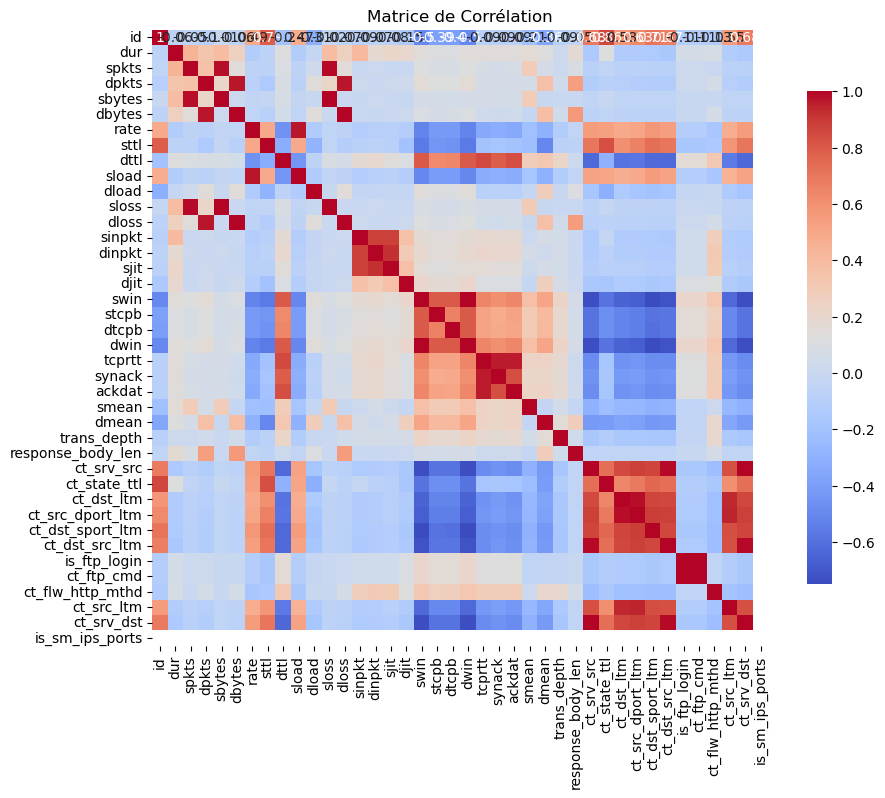

Dimensions de la matrice de corrélation : (81173, 61)


In [92]:
# Calculer la matrice de corrélation et arrondir les valeurs pour éviter le warning
correlation_matrix = data.select_dtypes(include=['float64', 'int64']).corr().round(2)

# Afficher la matrice de corrélation sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Matrice de Corrélation')
plt.show()
# Afficher les dimensions de la matrice de corrélation
print(f"Dimensions de la matrice de corrélation : {data.shape}")

Si deux variables ont une corrélation très élevée (par exemple > 0.9), cela peut indiquer qu'elles contiennent des informations similaires. Cela peut être utile pour la sélection des caractéristiques, car vous pourriez décider de ne garder qu'une seule des deux variables pour éviter la multicolinéarité dans les modèles de machine learning.

Features supprimées en raison d'une forte corrélation : set()
Dimensions des données après suppression des features corrélées : (81173, 48)


C:\Users\ce pc\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


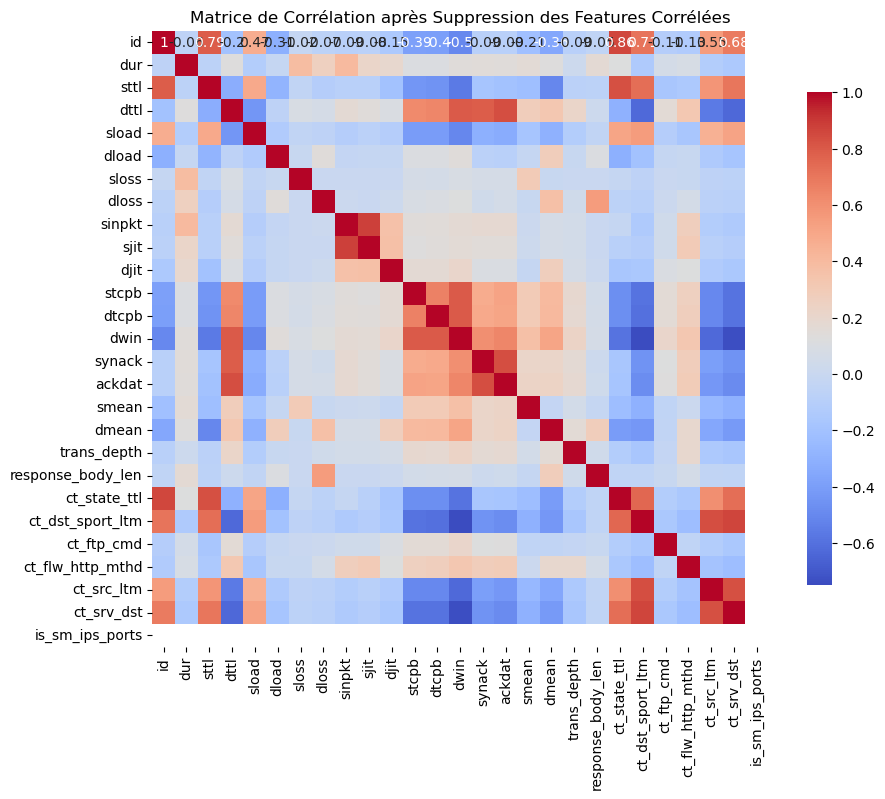

Dimensions de la matrice de corrélation : (81173, 48)


In [81]:
# Calculer la matrice de corrélation
correlation_matrix = data.select_dtypes(include=['float64', 'int64']).corr().round(2)

# Créer un ensemble des colonnes à supprimer pour éviter les doublons
columns_to_drop = set()

# Parcours de la matrice de corrélation pour identifier les paires fortement corrélées
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        # Si la corrélation est supérieure à 0.98, on marque une colonne à supprimer
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname1 = correlation_matrix.columns[i]
            colname2 = correlation_matrix.columns[j]
            
            # Si l'une des deux colonnes n'a pas encore été marquée pour suppression, on l'ajoute
            if colname2 not in columns_to_drop:
                columns_to_drop.add(colname2)  # On peut aussi décider d'ajouter`colname1` à la place de `colname2`

# Supprimer les colonnes corrélées
data.drop(columns=columns_to_drop, inplace=True)

# Afficher les colonnes supprimées et les dimensions finales
print("Features supprimées en raison d'une forte corrélation :", columns_to_drop)
print("Dimensions des données après suppression des features corrélées :", data.shape)

# Recalculer et afficher la matrice de corrélation après suppression des features corrélées
correlation_matrix_updated = data.select_dtypes(include=['float64', 'int64']).corr().round(2)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_updated, annot=True, cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Matrice de Corrélation après Suppression des Features Corrélées')
plt.show()
# Afficher les dimensions de la matrice de corrélation
print(f"Dimensions de la matrice de corrélation : {data.shape}")

la méthode de suréchantillonnage SMOTE pour équilibrer les classes dans l'ensemble d'entraînement, ce qui est particulièrement utile dans des problèmes de classification déséquilibrée où certaines classes sont largement sous-représentées.

 l'ensemble d'entraînement (70%) et l'ensemble de test (30%), selon un ratio de 70/30.
 
 random_state=42 : Définit une graine aléatoire pour que la division des données soit reproductible.

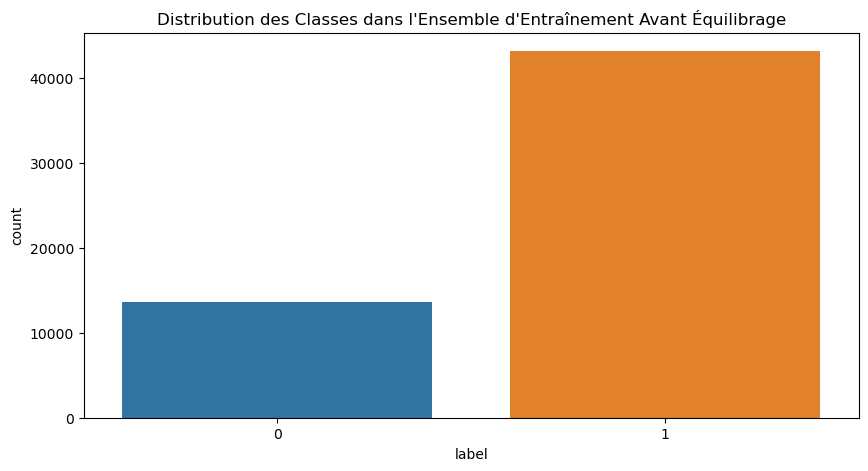

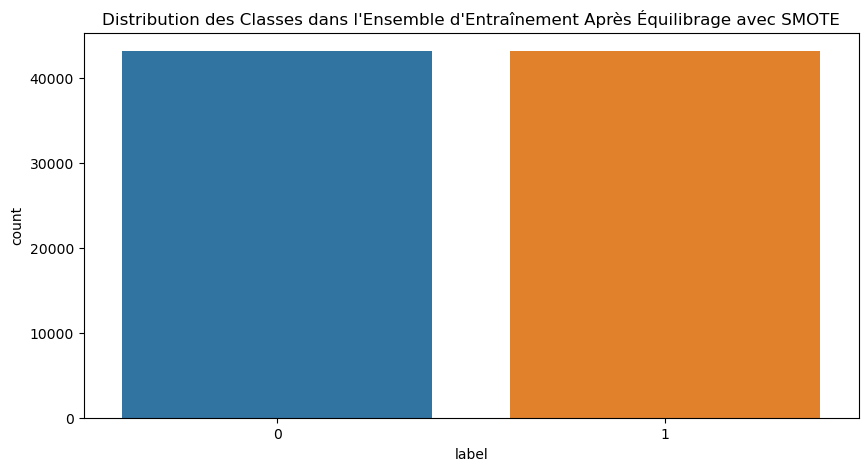

In [54]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Convertir les variables catégorielles en variables binaires (One-Hot Encoding)
X = pd.get_dummies(data.drop('label', axis=1), drop_first=True)  # Encodage des features
y = data['label']  # Colonne cible

# Diviser les données en ensembles de train et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Visualisation de la distribution des classes avant équilibrage sur l'ensemble d'entraînement
plt.figure(figsize=(10, 5))
sns.countplot(x=y_train)
plt.title("Distribution des Classes dans l'Ensemble d'Entraînement Avant Équilibrage")
plt.show()

# Application de SMOTE sur l'ensemble d'entraînement
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Conversion en DataFrame pour visualisation
data_train_resampled = pd.concat([pd.DataFrame(X_train_resampled, columns=X.columns), pd.DataFrame(y_train_resampled, columns=['label'])], axis=1)

# Visualisation de la distribution des classes après équilibrage avec SMOTE
plt.figure(figsize=(10, 5))
sns.countplot(x=y_train_resampled)
plt.title("Distribution des Classes dans l'Ensemble d'Entraînement Après Équilibrage avec SMOTE")
plt.show()

In [55]:
# Importer les bibliothèques pour KNN et Grid Search
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

 L'objectif est de trouver les meilleurs paramètres du modèle en fonction des données d'entraînement

                                      Param_distributions :
La première étape consiste à définir les plages de valeurs pour les hyperparamètres que nous voulons tester. Ces hyperparamètres influencent directement le comportement du modèle KNN.

n_neighbors : Le nombre de voisins à considérer pour la classification. Vous testez plusieurs valeurs (3, 5, 7, 9, 11) pour voir quelle valeur donne les meilleurs résultats.
weights : La méthode de pondération des voisins. Deux options sont disponibles :
uniform : Tous les voisins ont le même poids.
distance : Les voisins plus proches (selon la distance) auront un poids plus important.
metric : La distance utilisée pour calculer la proximité entre les points. Vous testez deux options :
euclidean : La distance Euclidienne, qui est la plus courante.
manhattan : La distance de Manhattan, qui calcule la somme des différences absolues entre les coordonnées.

In [56]:
# 1. Tuning KNN avec RandomizedSearchCV pour trouver les meilleurs paramètres
param_distributions = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
randomized_search = RandomizedSearchCV(
    KNeighborsClassifier(), param_distributions, n_iter=10, cv=5, n_jobs=-1, verbose=1, random_state=42
)
randomized_search.fit(X_train_resampled, y_train_resampled)

# Afficher les meilleurs paramètres et scores obtenus
best_knn = randomized_search.best_estimator_
print(f"Meilleurs paramètres : {randomized_search.best_params_}")
print(f"Meilleur score : {randomized_search.best_score_:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Meilleurs paramètres : {'weights': 'distance', 'n_neighbors': 3, 'metric': 'manhattan'}
Meilleur score : 0.9992


modèle KNN qui a été sélectionné après la recherche aléatoire (RandomizedSearchCV) avec les meilleurs hyperparamètres (c'est-à-dire les paramètres qui ont donné les meilleures performances pendant la recherche).

In [57]:
# 2. Entraîner le modèle KNN avec les meilleurs paramètres et évaluer sa performance
best_knn.fit(X_train_resampled, y_train_resampled)
y_pred = best_knn.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle KNN sur l'ensemble de test : {accuracy_test:.4f}")

Accuracy du modèle KNN sur l'ensemble de test : 0.9983


Ce bloc de code est destiné à visualiser les performances du modèle KNN en utilisant la courbe ROC (Receiver Operating Characteristic) et l'AUC (Area Under the Curve). 

Axes de la courbe :

Axe des X (FPR) : Le taux de faux positifs représente la proportion de négatifs incorrectement classés comme positifs.

Axe des Y (TPR) : Le taux de vrais positifs représente la proportion de positifs correctement classés.

Une courbe ROC qui se rapproche du coin supérieur gauche indique un modèle performant, car il a un taux de vrais positifs élevé et un taux de faux positifs faible. 
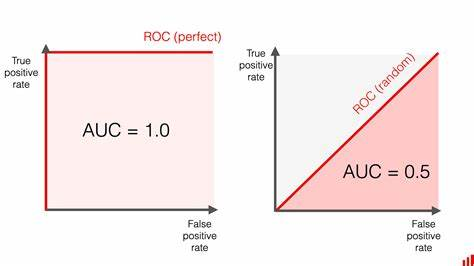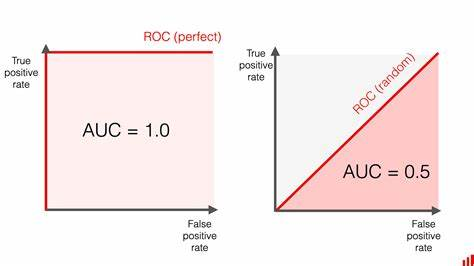

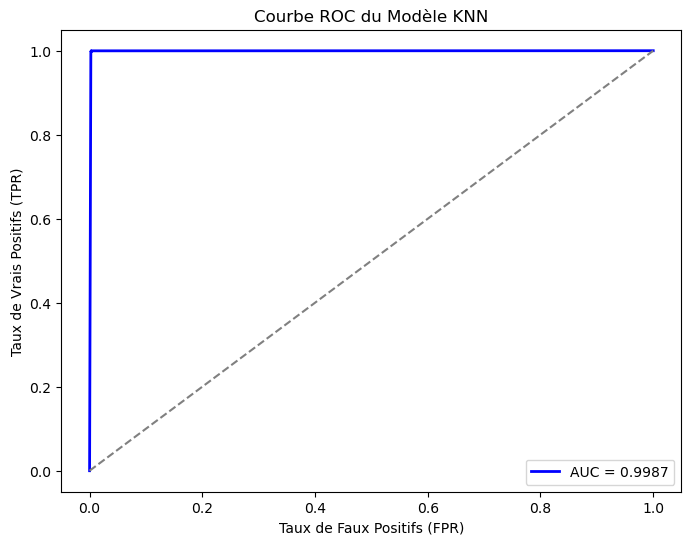

In [58]:
# 3. Visualisation des performances du modèle KNN
# Courbe ROC
y_pred_prob = best_knn.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC du Modèle KNN')
plt.legend(loc='lower right')
plt.show()

[[TN, FP],
 [FN, TP]]
 TN (True Negative) : Nombre de vrais négatifs, où le modèle a prédit 0 et la vérité était également 0.
FP (False Positive) : Nombre de faux positifs, où le modèle a prédit 1 mais la vérité était 0.
FN (False Negative) : Nombre de faux négatifs, où le modèle a prédit 0 mais la vérité était 1.
TP (True Positive) : Nombre de vrais positifs, où le modèle a prédit 1 et la vérité était également 1.

la resultat indiquer un modèle qui fait un excellent travail en classant correctement les éléments de la classe 0 (avec 5844 vrais négatifs), mais qui fait quelques erreurs pour identifier les éléments de la classe 1 (2 faux positifs).

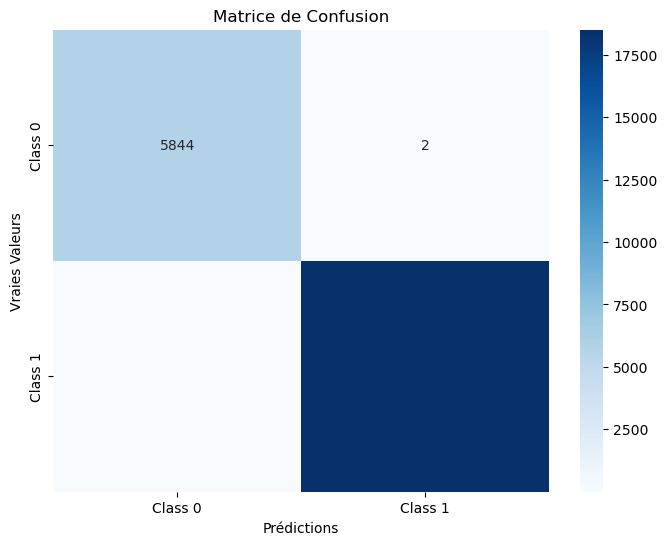

In [66]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vraies Valeurs")
plt.show()

Axes de la courbe :

Axe des X (Taille de l'ensemble d'entraînement) : Représente la proportion de l'ensemble d'entraînement utilisé pour entraîner le modèle.

Axe des Y (Accuracy) : Représente la précision du modèle, c'est-à-dire la proportion de prédictions correctes.



La courbe bleue montre comment la précision du modèle sur l'ensemble d'entraînement évolue à mesure que la taille de l'ensemble d'entraînement augmente.

La courbe verte montre comment la précision du modèle sur l'ensemble de test évolue à mesure que la taille de l'ensemble d'entraînement augmente.

Les zones ombrées montrent l'incertitude des mesures de précision.

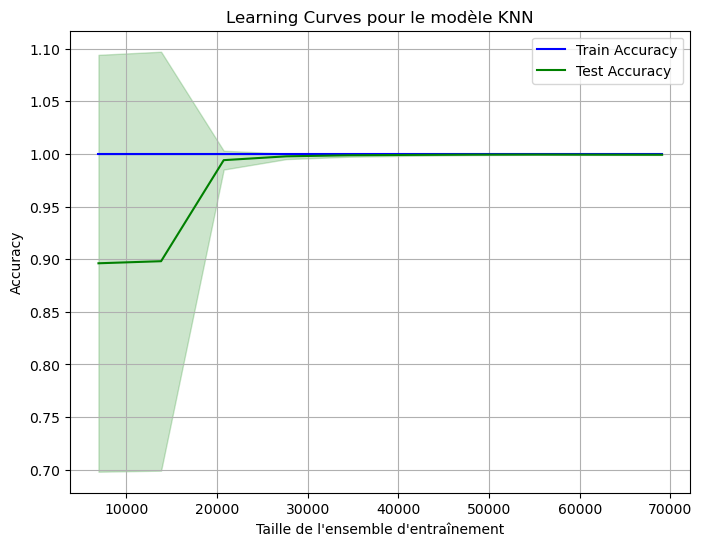

In [60]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# 1. Calculer les learning curves pour KNN
train_sizes, train_scores, test_scores = learning_curve(
    best_knn, X_train_resampled, y_train_resampled, cv=5, n_jobs=-1, train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
)

# 2. Calculer la moyenne et l'écart-type des scores d'entraînement et de test
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_std = test_scores.std(axis=1)

# 3. Visualiser les learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label="Train Accuracy", color="blue")
plt.plot(train_sizes, test_scores_mean, label="Test Accuracy", color="green")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="blue")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="green")
plt.title("Learning Curves pour le modèle KNN")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()


un MLP est un réseau de neurones profond qui apprend des représentations complexes à travers des couches successives pour effectuer des tâches de prédiction.

Dense : Couches entièrement connectées permettant au modèle d'apprendre des relations complexes entre les données.
ReLU : Fonction d'activation qui aide à accélérer l'entraînement en ajoutant de la non-linéarité.
Dropout : Technique de régularisation pour éviter l'overfitting en désactivant aléatoirement certains neurones.
Sigmoid : Fonction d'activation utilisée pour la classification binaire, générant des probabilités entre 0 et 1.

les couches ReLU extraient les caractéristiques essentielles et la couche sigmoid transforme le résultat final en une probabilité binaire, ce qui est adapté pour un problème de classification binaire.

L2 Regularization : Technique pour éviter que le modèle ne devienne trop complexe et n'apprenne des détails spécifiques des données d'entraînement

Optimisation :

Adam avec un learning rate de 0.0005 permet une descente de gradient efficace pour minimiser l’erreur (fonction binary crossentropy).


In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Modèle MLP avec régularisation et Dropout
mlp_model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_resampled.shape[1],), kernel_regularizer=l2(0.001)),
    Dropout(0.3),  # Désactive 30% des neurones pour éviter l'overfitting
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compilation avec un taux d'apprentissage plus bas
mlp_model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
history = mlp_model.fit(X_train_resampled, y_train_resampled, epochs=15, batch_size=32, validation_split=0.2)


C:\Users\ce pc\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9223 - loss: 0.2470 - val_accuracy: 0.9995 - val_loss: 0.0394
Epoch 2/15
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9985 - loss: 0.0412 - val_accuracy: 1.0000 - val_loss: 0.0212
Epoch 3/15
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9993 - loss: 0.0244 - val_accuracy: 1.0000 - val_loss: 0.0138
Epoch 4/15
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9995 - loss: 0.0167 - val_accuracy: 0.9999 - val_loss: 0.0105
Epoch 5/15
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9997 - loss: 0.0131 - val_accuracy: 1.0000 - val_loss: 0.0082
Epoch 6/15
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9997 - loss: 0.0108 - val_accuracy: 1.0000 - val_loss: 0.0071
Epoch 7/15
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9995 - loss: 0.0097 - val_accuracy: 1.0000 - val_loss: 0.0065
Epoch 8/15
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9998 - loss: 0.0089 - 

le modèle MLP a une précision (accuracy) très élevée, tant sur l'ensemble de test 

In [62]:
# Évaluation du modèle sur l'ensemble de test
mlp_loss_test, mlp_accuracy_test = mlp_model.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy du modèle MLP sur l'ensemble de test : {mlp_accuracy_test:.4f}")


Accuracy du modèle MLP sur l'ensemble de test : 0.9999


Courbe d'Accuracy (à gauche)
Axes :
Axe des X : Représente les époques, allant de 0 à 14.
Axe des Y : Représente l'accuracy (précision), allant de 0.975 à 1.000.

Courbes :
Courbe bleue : Représente l'accuracy de l'ensemble d'entraînement.
Courbe orange : Représente l'accuracy de l'ensemble de validation. 

Interprétation :
La courbe bleue montre comment la précision du modèle sur l'ensemble d'entraînement évolue au fil des époques.

La courbe orange montre comment la précision du modèle sur l'ensemble de validation évolue au fil des époques.

Si les deux courbes sont proches et élevées, cela indique que le modèle généralise bien sans surapprentissage (overfitting).


Courbe de Loss (à droite)
Axes :
Axe des X : Représente les époques, allant de 0 à 14.
Axe des Y : Représente la loss (perte), allant de 0.00 à 0.12.

Courbes :
Courbe bleue : Représente la loss de l'ensemble d'entraînement.
Courbe orange : Représente la loss de l'ensemble de validation.

Interprétation :
La courbe bleue montre comment la perte du modèle sur l'ensemble d'entraînement évolue au fil des époques.

La courbe orange montre comment la perte du modèle sur l'ensemble de validation évolue au fil des époques.

Une perte faible et stable sur les deux ensembles indique un bon ajustement du modèle.

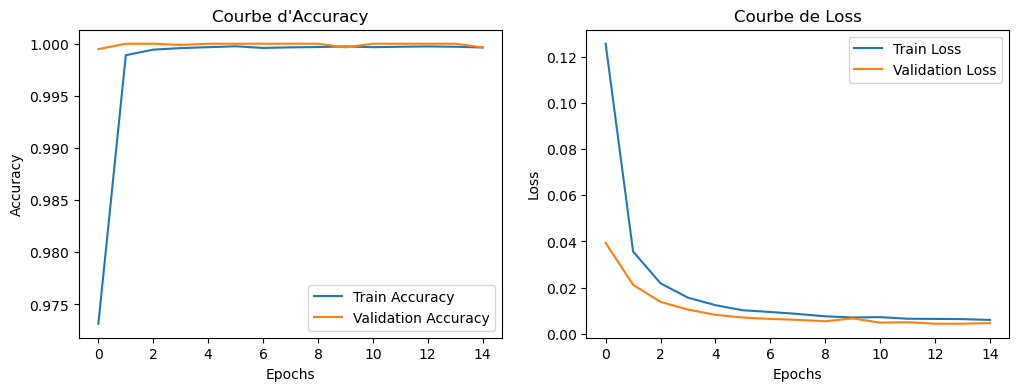

In [63]:
# 5. Afficher les courbes d'accuracy et de loss
plt.figure(figsize=(12, 4))

# Courbe d'accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Courbe d'Accuracy")

# Courbe de loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Courbe de Loss")

plt.show()


mlp_model.predict(X_test) : Cette fonction prédit les probabilités de chaque classe pour les échantillons dans l'ensemble de test. La sortie de cette prédiction est un nombre entre 0 et 1 (probabilité).
(mlp_model.predict(X_test) > 0.5) : Cette condition transforme la probabilité en une classe binaire. Si la probabilité est supérieure à 0.5, le modèle prédira la classe 1, sinon il prédira la classe 0.


761/761 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


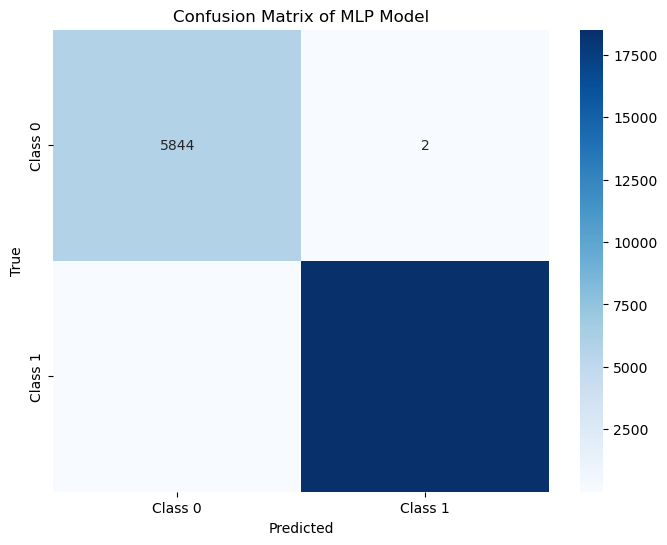

In [64]:
# Prédire les valeurs de l'ensemble de test
y_pred = (mlp_model.predict(X_test) > 0.5).astype("int32")  # Convert probabilities to binary class predictions

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Visualiser la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix of MLP Model")
plt.show()

La matrice de confusion montre que le modèle MLP a une très bonne performance avec un nombre élevé de vrais positifs et de vrais négatifs, et très peu de faux positifs et de faux négatifs. Cela indique que le modèle est très précis dans ses prédictions.

Vrais Positifs (TP) : 17554 - Nombre de fois où la classe 1 a été correctement prédite.

Faux Positifs (FP) : 2 - Nombre de fois où la classe 0 a été incorrectement prédite comme classe 1.

Faux Négatifs (FN) : 0 - Nombre de fois où la classe 1 a été incorrectement prédite comme classe 0.

Vrais Négatifs (TN) : 5844 - Nombre de fois où la classe 0 a été correctement prédite.

Conclusion :
Ce projet a permis de se concentrer sur la détection d'intrusions dans les réseaux en utilisant le dataset UNSW-NB15. Nous avons appliqué le modèle K-Nearest Neighbors (KNN), en utilisant la méthode GridSearchCV pour optimiser ses hyperparamètres, bien que le processus ait été exigeant en termes de temps de calcul. Par ailleurs, nous avons implémenté un modèle de deep learning de type Multi-Layer Perceptron (MLP) avec Keras, structuré avec des couches de 32 et 16 neurones et une régularisation par Dropout pour éviter le surapprentissage. Ce modèle a été entraîné pour une classification binaire, en utilisant des techniques d'optimisation pour affiner les résultats.

L'intérêt principal de ce projet réside dans l'exploration de différentes approches de machine learning et de deep learning pour la détection des intrusions réseau, en mettant l'accent sur les défis d'optimisation et de généralisation des modèles. Les résultats obtenus offrent une base solide pour le développement de systèmes de détection d'intrusions, contribuant à la sécurisation des réseaux face aux menaces potentielles.